In [5]:
import cv2
import sys
import glob
import time
import json
import yaml
import math
import numbers
import imageio
import argparse
import numpy as np
from typing import Optional
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from easydict import EasyDict as edict

import torch
import torchvision
from torch import nn
import pytorch3d.transforms
from torch.utils.tensorboard import SummaryWriter

import os
os.environ['GPU_DEBUG']='3'

In [10]:
project_path = '/home/youngju/youngju/NeRF/NeRF_Implementations/NeRF_models/NeRFACE/nerface'
print(os.listdir(project_path))
os.chdir(project_path)
print(os.getcwd())

['NerFACE_practice.ipynb', 'real_data', '.ipynb_checkpoints', 'renderings', '.DS_Store', 'logs']
/home/youngju/youngju/NeRF/NeRF_Implementations/NeRF_models/NeRFACE/nerface


In [11]:
def translate_by_t_along_z(t):
    """
    4x4 matrix 
    [1][0][0][0]
    [0][1][0][0]
    [0][0][1][t]
    [0][0][0][1]
    """
    tform = np.eye(4).astype(np.float32)
    tform[2][3] = t
    return tform


def rotate_by_phi_along_x(phi):
    """
    rotation matrix
    [1][0   ][0   ][0]
    [0][ cos][-sin][0]
    [0][ sin][ cos][0]
    [0][0   ][0   ][1]
    """
    tform = np.eye(4).astype(np.float32)
    tform[1, 1] = tform[2, 2] = np.cos(phi)
    tform[1, 2] = -np.sin(phi)
    tform[2, 1] = -tform[1, 2]
    return tform


def rotate_by_theta_along_y(theta):
    """
    rotation matrix
    [cos][0   ][-sin][0]
    [0  ][1   ][0   ][0]
    [sin][0   ][cos ][0]
    [0  ][0   ][0   ][1]
    """
    tform = np.eye(4).astype(np.float32)
    tform[0, 0] = tform[2, 2] = np.cos(theta)
    tform[0, 2] = -np.sin(theta)
    tform[2, 0] = -tform[0, 2]
    return tform


def pose_spherical(theta, phi, radius):
    c2w = translate_by_t_along_z(radius)
    c2w = rotate_by_phi_along_x(phi / 180.0 * np.pi) @ c2w
    c2w = rotate_by_theta_along_y(theta / 180 * np.pi) @ c2w
    c2w = np.array([[-1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]]) @ c2w
    return c2w


def load_flame_data(basedir, half_res=False, testskip=1, debug=False, expressions=True,load_frontal_faces=False, load_bbox=True, test=False):
    print("starting data loading")
    splits = ["train", "val", "test"]
    if test:
        splits = ["test"]
    metas = {}
    for s in splits:
        with open(os.path.join(basedir, f"transforms_{s}.json"), "r") as fp:
            metas[s] = json.load(fp)

    # 전체를 다 담는 리스트
    all_frontal_imgs = []
    all_imgs = []
    all_poses = []
    all_expressions = []
    all_bboxs = []
    
    counts = [0]
    for s in splits:
        meta = metas[s]
        imgs = []
        poses = []
        expressions = []
        frontal_imgs = []
        bboxs = []
        if s == "train" or testskip == 0:
            skip = 1
        else:
            skip = testskip
        if debug:
            skip = 100

        for frame in meta["frames"][::skip]:
            fname = os.path.join(basedir, frame["file_path"] + ".png")
            imgs.append(imageio.imread(fname))
            if load_frontal_faces:
                fname = os.path.join(basedir, frame["file_path"] + "_frontal" + ".png")
                frontal_imgs.append(imageio.imread(fname))

            poses.append(np.array(frame["transform_matrix"]))
            expressions.append(np.array(frame["expression"]))
            if load_bbox:
                if "bbox" not in frame.keys():
                    bboxs.append(np.array([0.0,1.0,0.0,1.0])) # full box
                else:
                    bboxs.append(np.array(frame["bbox"]))

        imgs = (np.array(imgs) / 255.0).astype(np.float32)
        if load_frontal_faces:
            frontal_imgs = (np.array(frontal_imgs) / 255.0).astype(np.float32)

        poses = np.array(poses).astype(np.float32)
        expressions = np.array(expressions).astype(np.float32)
        bboxs = np.array(bboxs).astype(np.float32)

        counts.append(counts[-1] + imgs.shape[0])
        all_imgs.append(imgs)
        all_frontal_imgs.append(frontal_imgs)
        all_poses.append(poses)
        all_expressions.append(expressions)
        all_bboxs.append(bboxs)

    i_split = [np.arange(counts[i], counts[i + 1]) for i in range(len(splits))]

    imgs = np.concatenate(all_imgs, 0)
    frontal_imgs = np.concatenate(all_frontal_imgs, 0) if load_frontal_faces else None
    poses = np.concatenate(all_poses, 0)
    expressions = np.concatenate(all_expressions, 0)
    bboxs = np.concatenate(all_bboxs, 0)

    H, W = imgs[0].shape[:2]
    camera_angle_x = float(meta["camera_angle_x"])
    focal = 0.5 * W / np.tan(0.5 * camera_angle_x)

    intrinsics = meta["intrinsics"] if meta["intrinsics"] else None
    if meta["intrinsics"]:
        intrinsics = np.array(meta["intrinsics"])
    else:
        intrinsics = np.array([focal, focal, 0.5, 0.5]) # fx fy cx cy

    render_poses = torch.stack(
        [
            torch.from_numpy(pose_spherical(angle, -30.0, 4.0))
            for angle in np.linspace(-180, 180, 40 + 1)[:-1]
        ],
        0,
    )


    if half_res:
        # TODO: resize images using INTER_AREA (cv2)
        H = H // 2
        W = W // 2
        #focal = focal / 2.0
        intrinsics[:2] = intrinsics[:2] * 0.5
        imgs = [
            torch.from_numpy(
                #cv2.resize(imgs[i], dsize=(400, 400), interpolation=cv2.INTER_AREA)
                cv2.resize(imgs[i], dsize=(H, W), interpolation=cv2.INTER_AREA)
            )
            for i in range(imgs.shape[0])
        ]
        imgs = torch.stack(imgs, 0)
        if load_frontal_faces:
            frontal_imgs = [
                torch.from_numpy(
                    #cv2.resize(imgs[i], dsize=(400, 400), interpolation=cv2.INTER_AREA)
                    cv2.resize(frontal_imgs[i], dsize=(H, W), interpolation=cv2.INTER_AREA)
                )
                for i in range(frontal_imgs.shape[0])
            ]
            frontal_imgs = torch.stack(frontal_imgs, 0)

    else:
        imgs = [
            torch.from_numpy(imgs[i]
                # cv2.resize(imgs[i], dsize=(400, 400), interpolation=cv2.INTER_AREA)
                #cv2.resize(imgs[i], dsize=(H, W), interpolation=cv2.INTER_AREA)
            )
            for i in range(imgs.shape[0])
        ]
        imgs = torch.stack(imgs, 0)
        if load_frontal_faces:
            frontal_imgs = [
                torch.from_numpy(frontal_imgs[i]
                                 # cv2.resize(imgs[i], dsize=(400, 400), interpolation=cv2.INTER_AREA)
                                 # cv2.resize(imgs[i], dsize=(H, W), interpolation=cv2.INTER_AREA)
                                 )
                for i in range(frontal_imgs.shape[0])
            ]
            frontal_imgs = torch.stack(frontal_imgs, 0)

    poses = torch.from_numpy(poses)
    expressions = torch.from_numpy(expressions)
    bboxs[:,0:2] *= H
    bboxs[:,2:4] *= W
    bboxs = np.floor(bboxs)
    bboxs = torch.from_numpy(bboxs).int()
    print("Done with data loading")

    return imgs, poses, render_poses, [H, W, intrinsics], i_split, expressions, frontal_imgs, bboxs

In [12]:
# data practice
basedir = './real_data/person_1'

imgs, poses, render_poses, [H, W, intrinsics], i_split, expressions, frontal_imgs, bboxs = load_flame_data(basedir, debug=True)


starting data loading


/tmp/ipykernel_25959/1132099695.py:84: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imgs.append(imageio.imread(fname))


Done with data loading


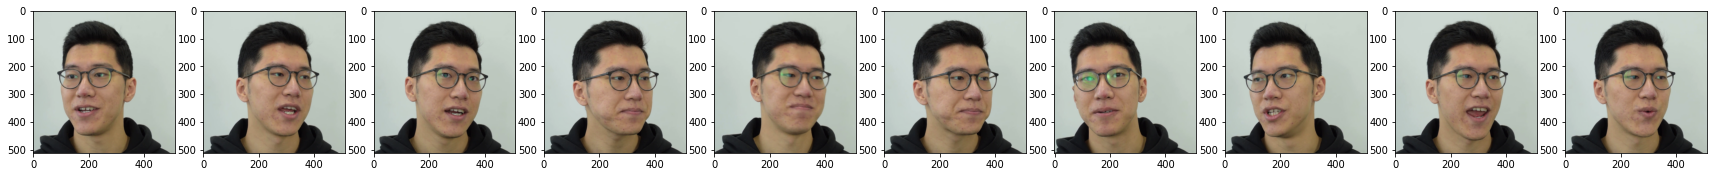

In [13]:
fix, axis = plt.subplots(1, 10, figsize=(30,300))
for i in range(10):
    axis[i].imshow(imgs[i])

In [8]:
def positional_encoding(
    tensor, num_encoding_functions=6, include_input=True, log_sampling=True
) -> torch.Tensor:
    r"""Apply positional encoding to the input.
    Args:
        tensor (torch.Tensor): Input tensor to be positionally encoded.
        encoding_size (optional, int): Number of encoding functions used to compute
            a positional encoding (default: 6).
        include_input (optional, bool): Whether or not to include the input in the
            positional encoding (default: True).
    Returns:
    (torch.Tensor): Positional encoding of the input tensor.
    """
    # TESTED
    # Trivially, the input tensor is added to the positional encoding.
    encoding = [tensor] if include_input else []
    frequency_bands = None
    if log_sampling:
        frequency_bands = 2.0 ** torch.linspace(
            0.0,
            num_encoding_functions - 1,
            num_encoding_functions,
            dtype=tensor.dtype,
            device=tensor.device,
        )
    else:
        frequency_bands = torch.linspace(
            2.0 ** 0.0,
            2.0 ** (num_encoding_functions - 1),
            num_encoding_functions,
            dtype=tensor.dtype,
            device=tensor.device,
        )

    for freq in frequency_bands:
        for func in [torch.sin, torch.cos]:
            encoding.append(func(tensor * freq))

    # Special case, for no positional encoding
    if len(encoding) == 1:
        return encoding[0]
    else:
        return torch.cat(encoding, dim=-1)


def get_embedding_function(
    num_encoding_functions=6, include_input=True, log_sampling=True
):
    r"""Returns a lambda function that internally calls positional_encoding.
    """
    return lambda x: positional_encoding(
        x, num_encoding_functions, include_input, log_sampling
    )

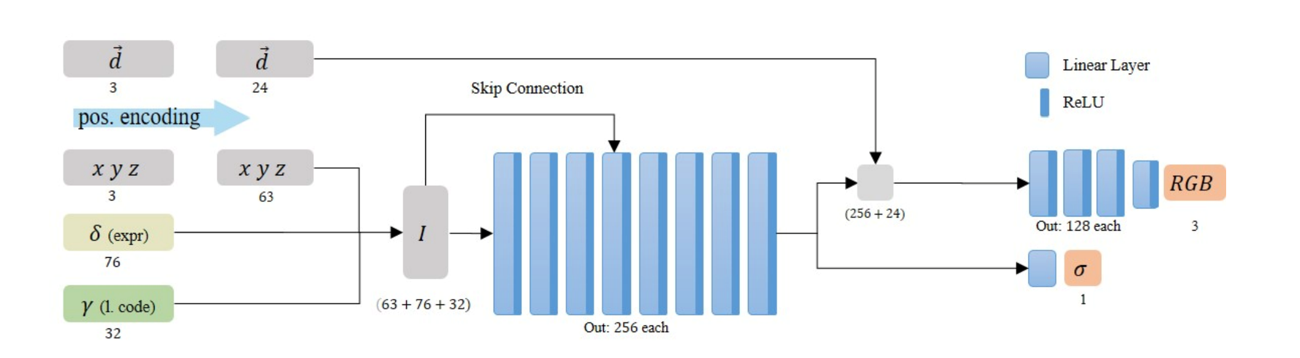

In [21]:
class NeRFACEModel(torch.nn.Module):
    r"""Implements the NeRF model as described in Fig. 7 (appendix) of the
    arXiv submission (v0). """
    
    def __init__(
        self,
        num_layers=8,
        hidden_size=256,
        skip_connect_every=4,
        num_encoding_fn_xyz=6,
        num_encoding_fn_dir=4,
        include_input_xyz=True,
        include_input_dir=True,
        use_viewdirs=True,
        include_expression=True,
        latent_code_dim=32

    ):
        
        super(NeRFACEModel, self).__init__()
        
        include_input_xyz = 3 if include_input_xyz else 0
        include_input_dir = 3 if include_input_dir else 0
        include_expression = 76 if include_expression else 0
        
        self.dim_xyz = include_input_xyz + 2 * 3 * num_encoding_fn_xyz # 63
        self.dim_dir = include_input_dir + 2 * 3 * num_encoding_fn_dir # 27
        self.dim_expression = include_expression
        self.dim_latent_code = latent_code_dim
        
        self.layers_xyz = torch.nn.ModuleList()
        self.use_viewdirs = use_viewdirs
        self.layers_xyz.append(torch.nn.Linear(self.dim_xyz + self.dim_expression + self.dim_latent_code, 256))
        
        for i in range(1, 6):
            if i == 3:
                self.layers_xyz.append(self.dim_xyz + self.dim_expression + self.dim_latent_code + 256, 256)
            else:
                self.layers_xyz.append(torch.nn.Linear(256, 256))
        
        self.fc_feat = torch.nn.Linear(256, 256)
        self.fc_alpha = torch.nn.Linear(256, 1)
        
        self.layers_dir = torch.nn.ModuleList()
        self.layers_dir.append(torch.nn.Linear(256+self.dim_dir, 128))
        for i in range(3):
            self.layers_dir.append(torch.nn.Linear(128, 128))
        self.fc_rgb = torch.nn.Linear(128, 3)
        self.relu = torch.nn.functional.relu
        
    def forward(self, x,  expr=None, latent_code=None, **kwargs):
        xyz, dirs = x[..., :self.dim_xyz], x[..., self.dim_xyz:]
        x = xyz
        latent_code = latent_code.repeat(xyz.shape[0], 1)
        if self.dim_expression > 0:
            expr_encoding = (expr * 1 /3).repeat(xyz.shape[0], 1)
            initial = torch.cat((xyz, expr_encoding, latent_code), dim=1)
            x = initial
        for i in range(6):
            if i == 3:
                x = self.layers_xyz[i](torch.cat((initial, x), -1))
            else:
                x = self.layers_xyz[i](x)
            x = self.relu(x)
        feat = self.fc_feat(x)
        alpha = self.fc_alpha(feat)

        if self.use_viewdirs:
            x = self.layers_dir[0](torch.cat((feat, dirs), -1))
        else:
            x = self.layers_dir[0](feat)
        x = self.relu(x)
        for i in range(1,3):
            x = self.layers_dir[i](x)
            x = self.relu(x)
        rgb = self.fc_rgb(x)

        return torch.cat((rgb, alpha), dim=-1)
            

In [10]:
def run_network(network_fn, pts, ray_batch, chunksize, embed_fn, embeddirs_fn, expressions = None, latent_code = None):

    pts_flat = pts.reshape((-1, pts.shape[-1]))
    embedded = embed_fn(pts_flat)
    if embeddirs_fn is not None:
        viewdirs = ray_batch[..., None, -3:]
        input_dirs = viewdirs.expand(pts.shape)
        input_dirs_flat = input_dirs.reshape((-1, input_dirs.shape[-1]))
        embedded_dirs = embeddirs_fn(input_dirs_flat)
        embedded = torch.cat((embedded, embedded_dirs), dim=-1)

    batches = get_minibatches(embedded, chunksize=chunksize)
    if expressions is None:
        preds = [network_fn(batch) for batch in batches]
    elif latent_code is not None:
        preds = [network_fn(batch, expressions, latent_code) for batch in batches]
    else:
        preds = [network_fn(batch, expressions) for batch in batches]
    radiance_field = torch.cat(preds, dim=0)
    radiance_field = radiance_field.reshape(
        list(pts.shape[:-1]) + [radiance_field.shape[-1]]
    )

    del embedded, input_dirs_flat
    return radiance_field


def predict_and_render_radiance(
    ray_batch,
    model_coarse,
    model_fine,
    options,
    mode="train",
    encode_position_fn=None,
    encode_direction_fn=None,
    expressions = None,
    background_prior = None,
    latent_code = None,
    ray_dirs_fake = None
):
    # TESTED
    num_rays = ray_batch.shape[0]
    ro, rd = ray_batch[..., :3], ray_batch[..., 3:6].clone() # TODO remove clone ablation rays
    bounds = ray_batch[..., 6:8].view((-1, 1, 2))
    near, far = bounds[..., 0], bounds[..., 1]
    # TODO: Use actual values for "near" and "far" (instead of 0. and 1.)
    # when not enabling "ndc".
    t_vals = torch.linspace(
        0.0,
        1.0,
        getattr(options.nerf, mode).num_coarse,
        dtype=ro.dtype,
        device=ro.device,
    )
    if not getattr(options.nerf, mode).lindisp:
        z_vals = near * (1.0 - t_vals) + far * t_vals
    else:
        z_vals = 1.0 / (1.0 / near * (1.0 - t_vals) + 1.0 / far * t_vals)
    z_vals = z_vals.expand([num_rays, getattr(options.nerf, mode).num_coarse])

    if getattr(options.nerf, mode).perturb:
        # Get intervals between samples.
        mids = 0.5 * (z_vals[..., 1:] + z_vals[..., :-1])
        upper = torch.cat((mids, z_vals[..., -1:]), dim=-1)
        lower = torch.cat((z_vals[..., :1], mids), dim=-1)
        # Stratified samples in those intervals.
        t_rand = torch.rand(z_vals.shape, dtype=ro.dtype, device=ro.device)
        z_vals = lower + (upper - lower) * t_rand
    # pts -> (num_rays, N_samples, 3)
    pts = ro[..., None, :] + rd[..., None, :] * z_vals[..., :, None]
    # Uncomment to dump a ply file visualizing camera rays and sampling points
    #dump_rays(ro.detach().cpu().numpy(), pts.detach().cpu().numpy())
    if ray_dirs_fake:
        ray_batch[...,3:6] = ray_dirs_fake[0][...,3:6]

    radiance_field = run_network(
        model_coarse,
        pts,
        ray_batch,
        getattr(options.nerf, mode).chunksize,
        encode_position_fn,
        encode_direction_fn,
        expressions,
        latent_code
    )
    # make last RGB values of each ray, the background
    if background_prior is not None:
        radiance_field[:,-1,:3] = background_prior

    (
        rgb_coarse,
        disp_coarse,
        acc_coarse,
        weights,
        depth_coarse,
    ) = volume_render_radiance_field(
        radiance_field,
        z_vals,
        rd,
        radiance_field_noise_std=getattr(options.nerf, mode).radiance_field_noise_std,
        white_background=getattr(options.nerf, mode).white_background,
        background_prior=background_prior
    )

    rgb_fine, disp_fine, acc_fine = None, None, None
    if getattr(options.nerf, mode).num_fine > 0:
        # rgb_map_0, disp_map_0, acc_map_0 = rgb_map, disp_map, acc_map

        z_vals_mid = 0.5 * (z_vals[..., 1:] + z_vals[..., :-1])
        z_samples = sample_pdf(
            z_vals_mid,
            weights[..., 1:-1],
            getattr(options.nerf, mode).num_fine,
            det=(getattr(options.nerf, mode).perturb == 0.0),
        )
        z_samples = z_samples.detach()

        z_vals, _ = torch.sort(torch.cat((z_vals, z_samples), dim=-1), dim=-1)
        # pts -> (N_rays, N_samples + N_importance, 3)
        pts = ro[..., None, :] + rd[..., None, :] * z_vals[..., :, None]

        radiance_field = run_network(
            model_fine,
            pts,
            ray_batch,
            getattr(options.nerf, mode).chunksize,
            encode_position_fn,
            encode_direction_fn,
            expressions,
            latent_code
        )
        # make last RGB values of each ray, the background
        if background_prior is not None:
            radiance_field[:, -1, :3] = background_prior

        # Uncomment to dump a ply file visualizing camera rays and sampling points
        #dump_rays(ro.detach().cpu().numpy(), pts.detach().cpu().numpy(), radiance_field)

        #dump_rays(ro.detach().cpu().numpy(), pts.detach().cpu().numpy(), torch.softmax(radiance_field[:,:,-1],1).detach().cpu().numpy())

        #rgb_fine, disp_fine, acc_fine, _, depth_fine = volume_render_radiance_field(
        rgb_fine, disp_fine, acc_fine, weights, depth_fine = volume_render_radiance_field( # added use of weights
            radiance_field,
            z_vals,
            rd,
            radiance_field_noise_std=getattr(
                options.nerf, mode
            ).radiance_field_noise_std,
            white_background=getattr(options.nerf, mode).white_background,
            background_prior=background_prior
        )

    #return rgb_coarse, disp_coarse, acc_coarse, rgb_fine, disp_fine, acc_fine, depth_fine #added depth fine
    return rgb_coarse, disp_coarse, acc_coarse, rgb_fine, disp_fine, acc_fine, weights[:,-1] #changed last return val to fine_weights


def run_one_iter_of_nerf(
    height,
    width,
    focal_length,
    model_coarse,
    model_fine,
    ray_origins,
    ray_directions,
    options,
    mode="train",
    encode_position_fn=None,
    encode_direction_fn=None,
    expressions = None,
    background_prior=None,
    latent_code = None,
    ray_directions_ablation = None
):
    is_rad = torch.is_tensor(ray_directions_ablation)
    viewdirs = None
    if options.nerf.use_viewdirs:
        # Provide ray directions as input
        viewdirs = ray_directions
        viewdirs = viewdirs / viewdirs.norm(p=2, dim=-1).unsqueeze(-1)
        viewdirs = viewdirs.view((-1, 3))
    # Cache shapes now, for later restoration.
    restore_shapes = [
        ray_directions.shape,
        ray_directions.shape[:-1],
        ray_directions.shape[:-1],
    ]
    if model_fine:
        restore_shapes += restore_shapes
        restore_shapes += [ray_directions.shape[:-1]] # to return fine depth map
    if options.dataset.no_ndc is False:
        #print("calling ndc")
        ro, rd = ndc_rays(height, width, focal_length, 1.0, ray_origins, ray_directions)
        ro = ro.view((-1, 3))
        rd = rd.view((-1, 3))
    else:
        #print("calling ndc")
        #"caling normal rays (not NDC)"
        ro = ray_origins.view((-1, 3))
        rd = ray_directions.view((-1, 3))
        if is_rad:
            rd_ablations = ray_directions_ablation.view((-1, 3))
    near = options.dataset.near * torch.ones_like(rd[..., :1])
    far = options.dataset.far * torch.ones_like(rd[..., :1])
    rays = torch.cat((ro, rd, near, far), dim=-1)
    if is_rad:
        rays_ablation = torch.cat((ro, rd_ablations, near, far), dim=-1)
    if options.nerf.use_viewdirs: # TODO uncomment
        rays = torch.cat((rays, viewdirs), dim=-1)
    #
    #viewdirs = None  # TODO remove this paragraph
    if options.nerf.use_viewdirs:
        # Provide ray directions as input
        if is_rad:
            viewdirs = ray_directions_ablation
            viewdirs = viewdirs / viewdirs.norm(p=2, dim=-1).unsqueeze(-1)
            viewdirs = viewdirs.view((-1, 3))


    if is_rad:
        batches_ablation = get_minibatches(rays_ablation, chunksize=getattr(options.nerf, mode).chunksize)
    batches = get_minibatches(rays, chunksize=getattr(options.nerf, mode).chunksize)
    assert(batches[0].shape == batches[0].shape)
    background_prior = get_minibatches(background_prior, chunksize=getattr(options.nerf, mode).chunksize) if\
        background_prior is not None else background_prior
    #print("predicting")
    if is_rad:
        pred = [
            predict_and_render_radiance(
                batch,
                model_coarse,
                model_fine,
                options,
                mode,
                encode_position_fn=encode_position_fn,
                encode_direction_fn=encode_direction_fn,
                expressions = expressions,
                background_prior = background_prior[i] if background_prior is not None else background_prior,
                latent_code = latent_code,
                ray_dirs_fake = batches_ablation
            )
            for i,batch in enumerate(batches)
        ]
    else:
        pred = [
            predict_and_render_radiance(
                batch,
                model_coarse,
                model_fine,
                options,
                mode,
                encode_position_fn=encode_position_fn,
                encode_direction_fn=encode_direction_fn,
                expressions = expressions,
                background_prior = background_prior[i] if background_prior is not None else background_prior,
                latent_code = latent_code,
                ray_dirs_fake = None
            )
            for i,batch in enumerate(batches)
        ]
    #print("predicted")

    synthesized_images = list(zip(*pred))
    synthesized_images = [
        torch.cat(image, dim=0) if image[0] is not None else (None)
        for image in synthesized_images
    ]
    if mode == "validation":
        synthesized_images = [
            image.view(shape) if image is not None else None
            for (image, shape) in zip(synthesized_images, restore_shapes)
        ]

        # Returns rgb_coarse, disp_coarse, acc_coarse, rgb_fine, disp_fine, acc_fine
        # (assuming both the coarse and fine networks are used).
        if model_fine:
            return tuple(synthesized_images)
        else:
            # If the fine network is not used, rgb_fine, disp_fine, acc_fine are
            # set to None.
            return tuple(synthesized_images + [None, None, None])

    return tuple(synthesized_images)

In [11]:
def volume_render_radiance_field(
    radiance_field,
    depth_values,
    ray_directions,
    radiance_field_noise_std=0.0,
    white_background=False,
    background_prior = None
):
    # TESTED
    one_e_10 = torch.tensor(
        [1e10], dtype=ray_directions.dtype, device=ray_directions.device
    )
    dists = torch.cat(
        (
            depth_values[..., 1:] - depth_values[..., :-1],
            one_e_10.expand(depth_values[..., :1].shape),
        ),
        dim=-1,
    )
    dists = dists * ray_directions[..., None, :].norm(p=2, dim=-1)


    if background_prior is not None:
        rgb = torch.sigmoid(radiance_field[:, :-1, :3])
        rgb = torch.cat((rgb, radiance_field[:, -1, :3].unsqueeze(1)), dim=1)
    else:
        rgb = torch.sigmoid(radiance_field[..., :3])

    # Experimental:
    #torch.autograd.set_detect_anomaly(True)
    #rgb = torch.sigmoid(radiance_field[..., :3])
    #if background_prior is not None:
    #    rgb[:,-1,:] = torch.ones(4096,3)#background_prior

    noise = 0.0
    if radiance_field_noise_std > 0.0:
        noise = (
            torch.randn(
                radiance_field[..., 3].shape,
                dtype=radiance_field.dtype,
                device=radiance_field.device,
            )
            * radiance_field_noise_std
        )
        # noise = noise.to(radiance_field)
    sigma_a = torch.nn.functional.relu(radiance_field[..., 3] + noise)
    #sigma_a[:,-1] += 1e-6 # todo commented this for FCB demo !!!!!!
    alpha = 1.0 - torch.exp(-sigma_a * dists)
    weights = alpha * cumprod_exclusive(1.0 - alpha + 1e-10)
    #weights[:, -1] *= 10
    #weights[:,:] = 0
    #weights[:,-1] = 1
    #weights = torch.softmax(weights, dim=1)
    #argmax_sigma = torch.argmax(sigma_a,dim=1)
    #surface_depth = torch.gather(depth_values, 1, argmax_sigma.unsqueeze(1))
    surface_depth = None
    rgb_map = weights[..., None] * rgb
    rgb_map = rgb_map.sum(dim=-2)
    depth_map = weights * depth_values
    depth_map = depth_map.sum(dim=-1)
    # depth_map = (weights * depth_values).sum(dim=-1)
    acc_map = weights.sum(dim=-1)
    disp_map = 1.0 / torch.max(1e-10 * torch.ones_like(depth_map), depth_map / acc_map)

    if white_background:
        rgb_map = rgb_map + (1.0 - acc_map[..., None])

    #return rgb_map, disp_map, acc_map, weights, depth_map
    return rgb_map, disp_map, acc_map, weights, surface_depth



In [12]:
def img2mse(img_src, img_tgt):
    return torch.nn.functional.mse_loss(img_src, img_tgt)


def mse2psnr(mse):
    # For numerical stability, avoid a zero mse loss.
    if mse == 0:
        mse = 1e-5
    return -10.0 * math.log10(mse)


def get_minibatches(inputs: torch.Tensor, chunksize: Optional[int] = 1024 * 8):
    r"""Takes a huge tensor (ray "bundle") and splits it into a list of minibatches.
    Each element of the list (except possibly the last) has dimension `0` of length
    `chunksize`.
    """
    return [inputs[i : i + chunksize] for i in range(0, inputs.shape[0], chunksize)]


def meshgrid_xy(
    tensor1: torch.Tensor, tensor2: torch.Tensor):
    """Mimick np.meshgrid(..., indexing="xy") in pytorch. torch.meshgrid only allows "ij" indexing.
    (If you're unsure what this means, safely skip trying to understand this, and run a tiny example!)

    Args:
      tensor1 (torch.Tensor): Tensor whose elements define the first dimension of the returned meshgrid.
      tensor2 (torch.Tensor): Tensor whose elements define the second dimension of the returned meshgrid.
    """
    # TESTED
    ii, jj = torch.meshgrid(tensor1, tensor2)
    return ii.transpose(-1, -2), jj.transpose(-1, -2)


def cumprod_exclusive(tensor: torch.Tensor) -> torch.Tensor:
    r"""Mimick functionality of tf.math.cumprod(..., exclusive=True), as it isn't available in PyTorch.

    Args:
    tensor (torch.Tensor): Tensor whose cumprod (cumulative product, see `torch.cumprod`) along dim=-1
      is to be computed.

    Returns:
    cumprod (torch.Tensor): cumprod of Tensor along dim=-1, mimiciking the functionality of
      tf.math.cumprod(..., exclusive=True) (see `tf.math.cumprod` for details).
    """
    # TESTED
    # Only works for the last dimension (dim=-1)
    dim = -1
    # Compute regular cumprod first (this is equivalent to `tf.math.cumprod(..., exclusive=False)`).
    cumprod = torch.cumprod(tensor, dim)
    # "Roll" the elements along dimension 'dim' by 1 element.
    cumprod = torch.roll(cumprod, 1, dim)
    # Replace the first element by "1" as this is what tf.cumprod(..., exclusive=True) does.
    cumprod[..., 0] = 1.0

    return cumprod


def get_ray_bundle(
    height: int, width: int, intrinsics , tform_cam2world: torch.Tensor, center = [0.5,0.5]
):
    r"""Compute the bundle of rays passing through all pixels of an image (one ray per pixel).

    Args:
    height (int): Height of an image (number of pixels).
    width (int): Width of an image (number of pixels).
    focal_length CHANGED TO INTRINSICS (float or torch.Tensor): Focal length (number of pixels, i.e., calibrated intrinsics).
    guy: changed focal length to array of fx fy
    intrinsics = [fx fy cx cy] where cx cy in [0,1] relative to image size
    tform_cam2world (torch.Tensor): A 6-DoF rigid-body transform (shape: :math:`(4, 4)`) that
      transforms a 3D point from the camera frame to the "world" frame for the current example.

    Returns:
    ray_origins (torch.Tensor): A tensor of shape :math:`(width, height, 3)` denoting the centers of
      each ray. `ray_origins[i][j]` denotes the origin of the ray passing through pixel at
      row index `j` and column index `i`.
      (TODO: double check if explanation of row and col indices convention is right).
    ray_directions (torch.Tensor): A tensor of shape :math:`(width, height, 3)` denoting the
      direction of each ray (a unit vector). `ray_directions[i][j]` denotes the direction of the ray
      passing through the pixel at row index `j` and column index `i`.
      (TODO: double check if explanation of row and col indices convention is right).
    """
    # TESTED
    ii, jj = meshgrid_xy(
        torch.arange(
            width, dtype=tform_cam2world.dtype, device=tform_cam2world.device
        ).to(tform_cam2world),
        torch.arange(
            height, dtype=tform_cam2world.dtype, device=tform_cam2world.device
        ),
    )
    # directions = torch.stack(
    #     [
    #         (ii - width * 0.5) / focal_length[0],
    #         -(jj - height * 0.5) / focal_length[1],
    #         -torch.ones_like(ii),
    #     ],
    #     dim=-1,
    #)
    if intrinsics.shape<(4,):
        intrinsics = [intrinsics, intrinsics, 0.5, 0.5]
    directions = torch.stack(
        [
            (ii - width * intrinsics[2]) / intrinsics[0],
            -(jj - height * intrinsics[3]) / intrinsics[1],
            -torch.ones_like(ii),
        ],
        dim=-1,
    )
    ray_directions = torch.sum(
        directions[..., None, :] * tform_cam2world[:3, :3], dim=-1
    )
    ray_origins = tform_cam2world[:3, -1].expand(ray_directions.shape)
    return ray_origins, ray_directions


def get_ray_bundle_axis_angles(
    height: int, width: int, intrinsics , tform_cam2world: torch.Tensor, center = [0.5,0.5]
):
    r"""Compute the bundle of rays passing through all pixels of an image (one ray per pixel).

    Args:
    height (int): Height of an image (number of pixels).
    width (int): Width of an image (number of pixels).
    focal_length CHANGED TO INTRINSICS (float or torch.Tensor): Focal length (number of pixels, i.e., calibrated intrinsics).
    guy: changed focal length to array of fx fy
    intrinsics = [fx fy cx cy] where cx cy in [0,1] relative to image size
    tform_cam2world (torch.Tensor):  shape [2,3] - tform_cam2world[0] is axis-angle of rotation.
    tform_cam2world[1] is translation.

    Returns:
    ray_origins (torch.Tensor): A tensor of shape :math:`(width, height, 3)` denoting the centers of
      each ray. `ray_origins[i][j]` denotes the origin of the ray passing through pixel at
      row index `j` and column index `i`.
      (TODO: double check if explanation of row and col indices convention is right).
    ray_directions (torch.Tensor): A tensor of shape :math:`(width, height, 3)` denoting the
      direction of each ray (a unit vector). `ray_directions[i][j]` denotes the direction of the ray
      passing through the pixel at row index `j` and column index `i`.
      (TODO: double check if explanation of row and col indices convention is right).
    """
    # TESTED
    ii, jj = meshgrid_xy(
        torch.arange(
            width, dtype=tform_cam2world.dtype, device=tform_cam2world.device
        ).to(tform_cam2world),
        torch.arange(
            height, dtype=tform_cam2world.dtype, device=tform_cam2world.device
        ),
    )
    # directions = torch.stack(
    #     [
    #         (ii - width * 0.5) / focal_length[0],
    #         -(jj - height * 0.5) / focal_length[1],
    #         -torch.ones_like(ii),
    #     ],
    #     dim=-1,
    #)
    if intrinsics.shape<(4,):
        intrinsics = [intrinsics, intrinsics, 0.5, 0.5]
    directions = torch.stack(
        [
            (ii - width * intrinsics[2]) / intrinsics[0],
            -(jj - height * intrinsics[3]) / intrinsics[1],
            -torch.ones_like(ii),
        ],
        dim=-1,
    )
    rot_mat = pytorch3d.transforms.so3_exponential_map(tform_cam2world[0].unsqueeze(0)).squeeze(0)
    ray_directions = torch.sum(
        directions[..., None, :] * rot_mat, dim=-1
    )


    #ray_origins = tform_cam2world[:3, -1].expand(ray_directions.shape)
    ray_origins = tform_cam2world[1].expand(ray_directions.shape)
    return ray_origins, ray_directions


def ndc_rays(H, W, focal, near, rays_o, rays_d):
    # TODO adapt to non central proj (cx cy not 0.5)
    # UNTESTED, but fairly sure.
    if not hasattr(focal, "__len__"): focal = [focal, focal]
    # Shift rays origins to near plane
    t = -(near + rays_o[..., 2]) / rays_d[..., 2]
    rays_o = rays_o + t[..., None] * rays_d

    # Projection
    o0 = -1.0 / (W / (2.0 * focal[0])) * rays_o[..., 0] / rays_o[..., 2]
    o1 = -1.0 / (H / (2.0 * focal[1])) * rays_o[..., 1] / rays_o[..., 2]
    o2 = 1.0 + 2.0 * near / rays_o[..., 2]

    d0 = (
        -1.0
        / (W / (2.0 * focal[0]))
        * (rays_d[..., 0] / rays_d[..., 2] - rays_o[..., 0] / rays_o[..., 2])
    )
    d1 = (
        -1.0
        / (H / (2.0 * focal[1]))
        * (rays_d[..., 1] / rays_d[..., 2] - rays_o[..., 1] / rays_o[..., 2])
    )
    d2 = -2.0 * near / rays_o[..., 2]

    rays_o = torch.stack([o0, o1, o2], -1)
    rays_d = torch.stack([d0, d1, d2], -1)

    return rays_o, rays_d


def gather_cdf_util(cdf, inds):
    r"""A very contrived way of mimicking a version of the tf.gather()
    call used in the original impl.
    """
    orig_inds_shape = inds.shape
    inds_flat = [inds[i].view(-1) for i in range(inds.shape[0])]
    valid_mask = [
        torch.where(ind >= cdf.shape[1], torch.zeros_like(ind), torch.ones_like(ind))
        for ind in inds_flat
    ]
    inds_flat = [
        torch.where(ind >= cdf.shape[1], (cdf.shape[1] - 1) * torch.ones_like(ind), ind)
        for ind in inds_flat
    ]
    cdf_flat = [cdf[i][ind] for i, ind in enumerate(inds_flat)]
    cdf_flat = [cdf_flat[i] * valid_mask[i] for i in range(len(cdf_flat))]
    cdf_flat = [
        cdf_chunk.reshape([1] + list(orig_inds_shape[1:])) for cdf_chunk in cdf_flat
    ]
    return torch.cat(cdf_flat, dim=0)


def sample_pdf(bins, weights, num_samples, det=False):
    # TESTED (Carefully, line-to-line).
    # But chances of bugs persist; haven't integration-tested with
    # training routines.

    # Get pdf
    weights = weights + 1e-5  # prevent nans
    pdf = weights / weights.sum(-1).unsqueeze(-1)
    cdf = torch.cumsum(pdf, -1)
    cdf = torch.cat((torch.zeros_like(cdf[..., :1]), cdf), -1)

    # Take uniform samples
    if det:
        u = torch.linspace(0.0, 1.0, num_samples).to(weights)
        u = u.expand(list(cdf.shape[:-1]) + [num_samples])
    else:
        u = torch.rand(list(cdf.shape[:-1]) + [num_samples]).to(weights)

    # Invert CDF
    inds = torch.searchsorted(
        cdf.contiguous(), u.contiguous(), side="right"
    )
    below = torch.max(torch.zeros_like(inds), inds - 1)
    above = torch.min((cdf.shape[-1] - 1) * torch.ones_like(inds), inds)
    inds_g = torch.stack((below, above), -1)
    orig_inds_shape = inds_g.shape

    cdf_g = gather_cdf_util(cdf, inds_g)
    bins_g = gather_cdf_util(bins, inds_g)

    denom = cdf_g[..., 1] - cdf_g[..., 0]
    denom = torch.where(denom < 1e-5, torch.ones_like(denom), denom)
    t = (u - cdf_g[..., 0]) / denom
    samples = bins_g[..., 0] + t * (bins_g[..., 1] - bins_g[..., 0])

    return samples


def sample_pdf_2(bins, weights, num_samples, det=False):
    r"""sample_pdf function from another concurrent pytorch implementation
    by yenchenlin (https://github.com/yenchenlin/nerf-pytorch).
    """

    weights = weights + 1e-5
    pdf = weights / torch.sum(weights, dim=-1, keepdim=True)
    cdf = torch.cumsum(pdf, dim=-1)
    cdf = torch.cat(
        [torch.zeros_like(cdf[..., :1]), cdf], dim=-1
    )  # (batchsize, len(bins))

    # Take uniform samples
    if det:
        u = torch.linspace(
            0.0, 1.0, steps=num_samples, dtype=weights.dtype, device=weights.device
        )
        u = u.expand(list(cdf.shape[:-1]) + [num_samples])
    else:
        u = torch.rand(
            list(cdf.shape[:-1]) + [num_samples],
            dtype=weights.dtype,
            device=weights.device,
        )

    # Invert CDF
    u = u.contiguous()
    cdf = cdf.contiguous()
    inds = torch.searchsorted(cdf.detach(), u, right=True)
    below = torch.max(torch.zeros_like(inds - 1), inds - 1)
    above = torch.min((cdf.shape[-1] - 1) * torch.ones_like(inds), inds)
    inds_g = torch.stack((below, above), dim=-1)  # (batchsize, num_samples, 2)

    matched_shape = (inds_g.shape[0], inds_g.shape[1], cdf.shape[-1])
    cdf_g = torch.gather(cdf.unsqueeze(1).expand(matched_shape), 2, inds_g)
    bins_g = torch.gather(bins.unsqueeze(1).expand(matched_shape), 2, inds_g)

    denom = cdf_g[..., 1] - cdf_g[..., 0]
    denom = torch.where(denom < 1e-5, torch.ones_like(denom), denom)
    t = (u - cdf_g[..., 0]) / denom
    samples = bins_g[..., 0] + t * (bins_g[..., 1] - bins_g[..., 0])

    return samples


In [15]:
def cast_to_image(tensor):
    # Input tensor is (H, W, 3). Convert to (3, H, W).
    tensor = tensor.permute(2, 0, 1)
    tensor = tensor.clamp(0.0,1.0)
    # Conver to PIL Image and then np.array (output shape: (H, W, 3))
    img = np.array(torchvision.transforms.ToPILImage()(tensor.detach().cpu()))
    # Map back to shape (3, H, W), as tensorboard needs channels first.
    img = np.moveaxis(img, [-1], [0])
    return img

def train(config, load_checkpoint, debug=False):
    # Read config file.

    cfg = None
    with open(config, "r") as f:
        cfg_dict = yaml.load(f, Loader=yaml.FullLoader)
        cfg = edict(cfg_dict)

    # If a pre-cached dataset is available, skip the dataloader.
    USE_CACHED_DATASET = False
    train_paths, validation_paths = None, None
    images, poses, render_poses, hwf, i_split, expressions = None, None, None, None, None, None
    H, W, focal, i_train, i_val, i_test = None, None, None, None, None, None

    # Load dataset
    images, poses, render_poses, hwf, expressions = None, None, None, None, None
    if cfg.dataset.type.lower() == "blender":
        images, poses, render_poses, hwf, i_split, expressions, _, bboxs = load_flame_data(
            cfg.dataset.basedir,
            half_res=cfg.dataset.half_res,
            testskip=cfg.dataset.testskip,
            debug=debug
        )
        i_train, i_val, i_test = i_split
        H, W, focal = hwf
        H, W = int(H), int(W)
        hwf = [H, W, focal]
        if cfg.nerf.train.white_background:
            images = images[..., :3] * images[..., -1:] + (1.0 - images[..., -1:])
    print("done loading data")
    # Seed experiment for repeatability
    seed = cfg.experiment.randomseed
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Device on which to run.
    if torch.cuda.is_available():
        device = "cuda" #+ ":" + str(cfg.experiment.device)
    else:
        device = "cpu"

    encode_position_fn = get_embedding_function(
        num_encoding_functions=cfg.models.coarse.num_encoding_fn_xyz,
        include_input=cfg.models.coarse.include_input_xyz,
        log_sampling=cfg.models.coarse.log_sampling_xyz,
    )

    encode_direction_fn = None
    if cfg.models.coarse.use_viewdirs:
        encode_direction_fn = get_embedding_function(
            num_encoding_functions=cfg.models.coarse.num_encoding_fn_dir,
            include_input=cfg.models.coarse.include_input_dir,
            log_sampling=cfg.models.coarse.log_sampling_dir,
        )

    # Initialize a coarse-resolution model.
    model_coarse = NerFACEModel(
        num_encoding_fn_xyz=cfg.models.coarse.num_encoding_fn_xyz,
        num_encoding_fn_dir=cfg.models.coarse.num_encoding_fn_dir,
        include_input_xyz=cfg.models.coarse.include_input_xyz,
        include_input_dir=cfg.models.coarse.include_input_dir,
        use_viewdirs=cfg.models.coarse.use_viewdirs,
        num_layers=cfg.models.coarse.num_layers,
        hidden_size=cfg.models.coarse.hidden_size,
        include_expression=True
    )
    model_coarse.to(device)
    # If a fine-resolution model is specified, initialize it.
    model_fine = None
    if hasattr(cfg.models, "fine"):
        model_fine = NerFACEModel(
            num_encoding_fn_xyz=cfg.models.fine.num_encoding_fn_xyz,
            num_encoding_fn_dir=cfg.models.fine.num_encoding_fn_dir,
            include_input_xyz=cfg.models.fine.include_input_xyz,
            include_input_dir=cfg.models.fine.include_input_dir,
            use_viewdirs=cfg.models.fine.use_viewdirs,
            num_layers = cfg.models.coarse.num_layers,
            hidden_size =cfg.models.coarse.hidden_size,
            include_expression=True
        )
        model_fine.to(device)

    ###################################
    ###################################
    train_background = False
    supervised_train_background = False
    blur_background = False

    train_latent_codes = True
    disable_expressions = False # True to disable expressions
    disable_latent_codes = False # True to disable latent codes
    fixed_background = True # Do False to disable BG
    regularize_latent_codes = True # True to add latent code LOSS, false for most experiments
    ###################################
    ###################################

    supervised_train_background = train_background and supervised_train_background

    if fixed_background: # load GT background
        print("loading GT background to condition on")
        from PIL import Image
        background = Image.open(os.path.join(cfg.dataset.basedir,'bg','00050.png'))
        background.thumbnail((H,W))
        background = torch.from_numpy(np.array(background).astype(np.float32)).to(device)
        background = background/255
        print("bg shape", background.shape)
        print("should be ", images[i_train][0].shape)
        assert background.shape == images[i_train][0].shape
    else:
        background = None

    # Initialize optimizer.
    trainable_parameters = list(model_coarse.parameters())
    if model_fine is not None:
        trainable_parameters += list(model_fine.parameters())
    if train_background:
        #background.requires_grad = True
        #trainable_parameters.append(background) # add it later when init optimizer for different lr
        print("background.is_leaf " ,background.is_leaf, background.device)

    if train_latent_codes:
        latent_codes = torch.zeros(len(i_train),32, device=device)
        print("initialized latent codes with shape %d X %d" % (latent_codes.shape[0], latent_codes.shape[1]))
        if not disable_latent_codes:
            trainable_parameters.append(latent_codes)
            latent_codes.requires_grad = True

    if train_background:
        optimizer = getattr(torch.optim, cfg.optimizer.type)(
            [{'params':trainable_parameters},
             {'params':background, 'lr':cfg.optimizer.lr}],
            lr=cfg.optimizer.lr
        )
    else:
        optimizer = getattr(torch.optim, cfg.optimizer.type)(
            [{'params':trainable_parameters},
             {'params': background, 'lr': cfg.optimizer.lr}        ], # this is obsolete but need for continuing training
            lr=cfg.optimizer.lr
        )
    # Setup logging.
    logdir = os.path.join(cfg.experiment.logdir, cfg.experiment.id)
    os.makedirs(logdir, exist_ok=True)
    writer = SummaryWriter(logdir)

    # By default, start at iteration 0 (unless a checkpoint is specified).
    start_iter = 0

    # Load an existing checkpoint, if a path is specified.
    if os.path.exists(load_checkpoint):
        checkpoint = torch.load(load_checkpoint)
        model_coarse.load_state_dict(checkpoint["model_coarse_state_dict"])
        if checkpoint["model_fine_state_dict"]:
            model_fine.load_state_dict(checkpoint["model_fine_state_dict"])
        if checkpoint["background"] is not None:
            print("loaded bg from checkpoint")
            background = torch.nn.Parameter(checkpoint['background'].to(device))
        if checkpoint["latent_codes"] is not None:
            print("loaded latent codes from checkpoint")
            latent_codes = torch.nn.Parameter(checkpoint['latent_codes'].to(device))

        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        start_iter = checkpoint["iter"]

    # Prepare importance sampling maps
    ray_importance_sampling_maps = []
    p = 0.9
    print("computing boundix boxes probability maps")
    for i in i_train:
        bbox = bboxs[i]
        probs = np.zeros((H,W))
        probs.fill(1-p)
        probs[bbox[0]:bbox[1],bbox[2]:bbox[3]] = p
        probs = (1/probs.sum()) * probs
        ray_importance_sampling_maps.append(probs.reshape(-1))


    print("Starting loop")
    for i in trange(start_iter, cfg.experiment.train_iters):

        model_coarse.train()
        if model_fine:
            model_fine.train()

        rgb_coarse, rgb_fine = None, None
        target_ray_values = None
        background_ray_values = None

        img_idx = np.random.choice(i_train)
        img_target = images[img_idx].to(device)
        pose_target = poses[img_idx, :3, :4].to(device)
        if not disable_expressions:
            expression_target = expressions[img_idx].to(device) # vector
        else: # zero expr
            expression_target = torch.zeros(76, device=device)
        #bbox = bboxs[img_idx]
        if not disable_latent_codes:
            latent_code = latent_codes[img_idx].to(device) if train_latent_codes else None
        else:
            latent_codes = torch.zeros(32, device=device)
        #latent_code = torch.zeros(32).to(device)
        ray_origins, ray_directions = get_ray_bundle(H, W, focal, pose_target)
        coords = torch.stack(
            meshgrid_xy(torch.arange(H).to(device), torch.arange(W).to(device)),
            dim=-1,
        )

        coords = coords.reshape((-1, 2))

        # Use importance sampling to sample mainly in the bbox with prob p
        select_inds = np.random.choice(
            coords.shape[0], size=(cfg.nerf.train.num_random_rays), replace=False, p=ray_importance_sampling_maps[img_idx]
        )

        select_inds = coords[select_inds]
        ray_origins = ray_origins[select_inds[:, 0], select_inds[:, 1], :]
        ray_directions = ray_directions[select_inds[:, 0], select_inds[:, 1], :]
        #dump_rays(ray_origins, ray_directions)

        # batch_rays = torch.stack([ray_origins, ray_directions], dim=0)
        target_s = img_target[select_inds[:, 0], select_inds[:, 1], :]
        background_ray_values = background[select_inds[:, 0], select_inds[:, 1], :] if (train_background or fixed_background) else None

        then = time.time()
        rgb_coarse, _, _, rgb_fine, _, _, weights = run_one_iter_of_nerf(
            H,
            W,
            focal,
            model_coarse,
            model_fine,
            ray_origins,
            ray_directions,
            cfg,
            mode="train",
            encode_position_fn=encode_position_fn,
            encode_direction_fn=encode_direction_fn,
            expressions = expression_target,
            background_prior=background_ray_values,
            latent_code = latent_code if not disable_latent_codes else torch.zeros(32,device=device)

        )
        target_ray_values = target_s

        coarse_loss = torch.nn.functional.mse_loss(
            rgb_coarse[..., :3], target_ray_values[..., :3]
        )
        fine_loss = None
        if rgb_fine is not None:
            fine_loss = torch.nn.functional.mse_loss(
                rgb_fine[..., :3], target_ray_values[..., :3]
            )
        loss = 0.0

        latent_code_loss = torch.zeros(1, device=device)
        if train_latent_codes and not disable_latent_codes:
            latent_code_loss = torch.norm(latent_code) * 0.0005

        background_loss = torch.zeros(1, device=device)
        if supervised_train_background:
            background_loss = torch.nn.functional.mse_loss(
                background_ray_values[..., :3], target_ray_values[..., :3], reduction='none'
            ).sum(1)
            background_loss = torch.mean(background_loss*weights) * 0.001

        loss = coarse_loss + (fine_loss if fine_loss is not None else 0.0)
        psnr = mse2psnr(loss.item())

        loss = loss + (latent_code_loss*10 if regularize_latent_codes else 0.0)
        loss_total = loss + (background_loss if supervised_train_background is not None else 0.0)
        loss_total.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Learning rate updates
        num_decay_steps = cfg.scheduler.lr_decay * 1000
        lr_new = cfg.optimizer.lr * (
            cfg.scheduler.lr_decay_factor ** (i / num_decay_steps)
        )
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr_new

        if i % cfg.experiment.print_every == 0 or i == cfg.experiment.train_iters - 1:
            tqdm.write(
                "[TRAIN] Iter: "
                + str(i)
                + " Loss: "
                + str(loss.item())
                + " BG Loss: "
                + str(background_loss.item())
                + " PSNR: "
                + str(psnr)
                + " LatentReg: "
                + str(latent_code_loss.item())
            )
        #writer.add_scalar("train/loss", loss.item(), i)
        if train_latent_codes:
            writer.add_scalar("train/code_loss", latent_code_loss.item(), i)
        if supervised_train_background:
            writer.add_scalar("train/bg_loss", background_loss.item(), i)

        writer.add_scalar("train/coarse_loss", coarse_loss.item(), i)
        if rgb_fine is not None:
            writer.add_scalar("train/fine_loss", fine_loss.item(), i)
        writer.add_scalar("train/psnr", psnr, i)

        # Validation
        if (
            i % cfg.experiment.validate_every == 0
            or i == cfg.experiment.train_iters - 1 and False
        ):
            #torch.cuda.empty_cache()
            tqdm.write("[VAL] =======> Iter: " + str(i))
            model_coarse.eval()
            if model_fine:
                model_coarse.eval()

            start = time.time()
            with torch.no_grad():
                rgb_coarse, rgb_fine = None, None
                target_ray_values = None
                
                # Do all validation set...
                loss = 0
                for img_idx in i_val[:2]:
                    img_target = images[img_idx].to(device)
                    #tqdm.set_description('val im %d' % img_idx)
                    #tqdm.refresh()  # to show immediately the update

                        # # save val image for debug ### DEBUG ####
                    # #GT = target_ray_values[..., :3]
                    # import PIL.Image
                    # #img = GT.permute(2, 0, 1)
                    # # Conver to PIL Image and then np.array (output shape: (H, W, 3))
                    # #im_numpy = img_target.detach().cpu().numpy()
                    # #im_numpy = np.array(torchvision.transforms.ToPILImage()(img_target.detach().cpu()))
                    #
                    # #                   im = PIL.Image.fromarray(im_numpy)
                    # im = img_target
                    # im = im.permute(2, 0, 1)
                    # img = np.array(torchvision.transforms.ToPILImage()(im.detach().cpu()))
                    # im = PIL.Image.fromarray(img)
                    # im.save('val_im_target_debug.png')
                    # ### DEBUG #### END

                    pose_target = poses[img_idx, :3, :4].to(device)
                    ray_origins, ray_directions = get_ray_bundle(
                        H, W, focal, pose_target
                    )
                    rgb_coarse, _, _, rgb_fine, _, _ ,weights= run_one_iter_of_nerf(
                        H,
                        W,
                        focal,
                        model_coarse,
                        model_fine,
                        ray_origins,
                        ray_directions,
                        cfg,
                        mode="validation",
                        encode_position_fn=encode_position_fn,
                        encode_direction_fn=encode_direction_fn,
                        expressions = expression_target,
                        background_prior = background.view(-1,3) if (train_background or fixed_background) else None,
                        latent_code = torch.zeros(32).to(device) if train_latent_codes or disable_latent_codes else None,

                    )
                    #print("did one val")
                    target_ray_values = img_target
                    coarse_loss = img2mse(rgb_coarse[..., :3], target_ray_values[..., :3])
                    curr_loss, curr_fine_loss = 0.0, 0.0
                    if rgb_fine is not None:
                        curr_fine_loss = img2mse(rgb_fine[..., :3], target_ray_values[..., :3])
                        curr_loss = curr_fine_loss
                    else:
                        curr_loss = coarse_loss
                    loss += curr_loss + curr_fine_loss

                loss /= len(i_val)
                psnr = mse2psnr(loss.item())
                writer.add_scalar("validation/loss", loss.item(), i)
                writer.add_scalar("validation/coarse_loss", coarse_loss.item(), i)
                writer.add_scalar("validation/psnr", psnr, i)
                writer.add_image(
                    "validation/rgb_coarse", cast_to_image(rgb_coarse[..., :3]), i
                )
                if rgb_fine is not None:
                    writer.add_image(
                        "validation/rgb_fine", cast_to_image(rgb_fine[..., :3]), i
                    )
                    writer.add_scalar("validation/fine_loss", fine_loss.item(), i)

                writer.add_image(
                    "validation/img_target",
                    cast_to_image(target_ray_values[..., :3]),
                    i,
                )
                if train_background or fixed_background:
                    writer.add_image(
                        "validation/background", cast_to_image(background[..., :3]), i
                    )
                    writer.add_image(
                        "validation/weights", (weights.detach().cpu().numpy()), i, dataformats='HW'
                    )
                tqdm.write(
                    "Validation loss: "
                    + str(loss.item())
                    + " Validation PSNR: "
                    + str(psnr)
                    + " Time: "
                    + str(time.time() - start)
                )


        if i % cfg.experiment.save_every == 0 or i == cfg.experiment.train_iters - 1:
            checkpoint_dict = {
                "iter": i,
                "model_coarse_state_dict": model_coarse.state_dict(),
                "model_fine_state_dict": None
                if not model_fine
                else model_fine.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": loss,
                "psnr": psnr,
                "background": None
                if not (train_background or fixed_background)
                else background.data,
                "latent_codes": None if not train_latent_codes else latent_codes.data
            }
            torch.save(
                checkpoint_dict,
                os.path.join(logdir, "checkpoint" + str(i).zfill(5) + ".ckpt"),
            )
            tqdm.write("================== Saved Checkpoint =================")

    print("Done!")


In [16]:
config = './real_data/person_1/person_1_config.yml'
load_checkpoint = ''
train(config, load_checkpoint, debug=True)

starting data loading
Done with data loading
done loading data
loading GT background to condition on
bg shape torch.Size([512, 512, 3])
should be  torch.Size([512, 512, 3])
initialized latent codes with shape 56 X 32
computing boundix boxes probability maps
Starting loop


  0%|          | 0/1000000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
  0%|          | 0/1000000 [00:05<?, ?it/s]

[TRAIN] Iter: 0 Loss: 0.5211434364318848 BG Loss: 0.0 PSNR: 2.8304272760754436 LatentReg: 0.0
[VAL] =======> Iter: 0


  0%|          | 0/1000000 [01:37<?, ?it/s]

Validation loss: 0.7906381487846375 Validation PSNR: 1.020222345074051 Time: 91.33515691757202


  0%|          | 1/1000000 [01:37<27133:13:53, 97.68s/it]

================== Saved Checkpoint =================


  0%|          | 101/1000000 [03:27<304:01:40,  1.09s/it]

[TRAIN] Iter: 100 Loss: 0.11515552550554276 BG Loss: 0.0 PSNR: 9.388603736385496 LatentReg: 3.848085725621786e-06


  0%|          | 111/1000000 [03:39<549:58:08,  1.98s/it]


KeyboardInterrupt: ignored

In [ ]:
def save_plt_image(im1, outname):
    fig = plt.figure()
    fig.set_size_inches((6.4,6.4))
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    #plt.set_cmap('jet')
    ax.imshow(im1, aspect='equal')
    plt.savefig(outname, dpi=80)
    plt.close(fig)


def normal_map_from_depth_map(depthmap):
    h, w = np.shape(depthmap)
    normals = np.zeros((h, w, 3))
    phong = np.zeros((h, w, 3))
    for x in range(1, h - 1):
        for y in range(1, w - 1):
            dzdx = (float((depthmap[x + 1, y])) - float((depthmap[x - 1, y]))) / 2.0
            dzdy = (float((depthmap[x, y + 1])) - float((depthmap[x, y - 1]))) / 2.0

            n = np.array([-dzdx, -dzdy, 0.005])

            n = n * 1/np.linalg.norm(n)
            dir = np.array([x,y,1.0])
            dir = dir *1/np.linalg.norm(dir)

            normals[x, y] = (n*0.5 + 0.5)
            phong[x, y] = np.dot(dir,n)*0.5+0.5

    normals *= 255
    normals = normals.astype('uint8')
    #plt.imshow(depthmap, cmap='gray')
    #plt.show()
    plt.imshow(normals)
    plt.show()
    plt.imshow(phong)
    plt.show()
    print('a')
    return normals

def torch_normal_map(depthmap,focal,weights=None,clean=True, central_difference=False):
    W,H = depthmap.shape
    #normals = torch.zeros((H,W,3), device=depthmap.device)
    cx = focal[2]*W
    cy = focal[3]*H
    fx = focal[0]
    fy = focal[1]
    ii, jj = meshgrid_xy(torch.arange(W, device=depthmap.device),
                         torch.arange(H, device=depthmap.device))
    points = torch.stack(
        [
            ((ii - cx) * depthmap) / fx,
            -((jj - cy) * depthmap) / fy,
            depthmap,
        ],
        dim=-1)
    difference = 2 if central_difference else 1
    dx = (points[difference:,:,:] - points[:-difference,:,:])
    dy = (points[:,difference:,:] - points[:,:-difference,:])
    normals = torch.cross(dy[:-difference,:,:],dx[:,:-difference,:],2)
    normalize_factor = torch.sqrt(torch.sum(normals*normals,2))
    normals[:,:,0]  /= normalize_factor
    normals[:,:,1]  /= normalize_factor
    normals[:,:,2]  /= normalize_factor
    normals = normals * 0.5 +0.5

    if clean and weights is not None: # Use volumetric rendering weights to clean up the normal map
        mask = weights.repeat(3,1,1).permute(1,2,0)
        mask = mask[:-difference,:-difference]
        where = torch.where(mask > 0.22)
        normals[where] = 1.0
        normals = (1-mask)*normals + (mask)*torch.ones_like(normals)
    normals *= 255
    #plt.imshow(normals.cpu().numpy().astype('uint8'))
    #plt.show()
    return normals

def vis(tensor):
    plt.imshow((tensor*255).cpu().numpy().astype('uint8'))
    plt.show()
def normal_map_from_depth_map_backproject(depthmap):
    h, w = np.shape(depthmap)
    normals = np.zeros((h, w, 3))
    phong = np.zeros((h, w, 3))
    cx = cy = h//2
    fx=fy=500
    fx = fy = 1150
    for x in range(1, h - 1):
        for y in range(1, w - 1):
            #dzdx = (float((depthmap[x + 1, y])) - float((depthmap[x - 1, y]))) / 2.0
            #dzdy = (float((depthmap[x, y + 1])) - float((depthmap[x, y - 1]))) / 2.0

            p = np.array([(x*depthmap[x,y]-cx)/fx, (y*depthmap[x,y]-cy)/fy, depthmap[x,y]])
            py = np.array([(x*depthmap[x,y+1]-cx)/fx, ((y+1)*depthmap[x,y+1]-cy)/fy, depthmap[x,y+1]])
            px = np.array([((x+1)*depthmap[x+1,y]-cx)/fx, (y*depthmap[x+1,y]-cy)/fy, depthmap[x+1,y]])

            #n = np.array([-dzdx, -dzdy, 0.005])
            n = np.cross(px-p, py-p)
            n = n * 1/np.linalg.norm(n)
            dir = p#np.array([x,y,1.0])
            dir = dir *1/np.linalg.norm(dir)

            normals[x, y] = (n*0.5 + 0.5)
            phong[x, y] = np.dot(dir,n)*0.5+0.5

    normals *= 255
    normals = normals.astype('uint8')
    #plt.imshow(depthmap, cmap='gray')
    #plt.show()
    #plt.imshow(normals)
    #plt.show()
    #plt.imshow(phong)
    #plt.show()
    #print('a')
    return normals

def error_image(im1, im2):
    fig = plt.figure()
    diff = (im1 - im2)
    #gt_vs_theirs[total_mask, :] = 0
    #print("theirs ", np.sqrt(np.sum(np.square(gt_vs_theirs))), np.mean(np.square(gt_vs_theirs)))
    ax = plt.axes([0, 0, 1, 1], frameon=False)
    # Then we disable our xaxis and yaxis completely. If we just say plt.axis('off'),
    # they are still used in the computation of the image padding.
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Even though our axes (plot region) are set to cover the whole image with [0,0,1,1],
    # by default they leave padding between the plotted data and the frame. We use tigher=True
    # to make sure the data gets scaled to the full extents of the axes.
    plt.autoscale(tight=True)
    plt.imshow(np.linalg.norm(diff, axis=2), cmap='jet')
    #ax.plt.axes('off')



    #ax = plt.Axes(fig, [0., 0., 1., 1.])
    #ax.set_axis_off()
    #plt.show()
    return fig

def cast_to_image(tensor, dataset_type):
    # Input tensor is (H, W, 3). Convert to (3, H, W).
    tensor = tensor.permute(2, 0, 1)
    tensor = tensor.clamp(0.0,1.0)
    # Convert to PIL Image and then np.array (output shape: (H, W, 3))
    img = np.array(torchvision.transforms.ToPILImage()(tensor.detach().cpu()))
    return img
    # # Map back to shape (3, H, W), as tensorboard needs channels first.
    # return np.moveaxis(img, [-1], [0])


def cast_to_disparity_image(tensor):
    img = (tensor - tensor.min()) / (tensor.max() - tensor.min())
    img = img.clamp(0, 1) * 255
    return img.detach().cpu().numpy().astype(np.uint8)

In [ ]:
def eval(config, checkpoint, savedir, save_disparity_image=True, save_error_image=True):

    # Read config file.
    cfg = None
    with open(config, "r") as f:
        cfg_dict = yaml.load(f, Loader=yaml.FullLoader)
        cfg = edict(cfg_dict)

    images, poses, render_poses, hwf = None, None, None, None
    i_train, i_val, i_test = None, None, None
    if cfg.dataset.type.lower() == "blender":
        # Load blender dataset
        images, poses, render_poses, hwf, i_split, expressions, _, _ = load_flame_data(
            cfg.dataset.basedir,
            half_res=cfg.dataset.half_res,
            testskip=cfg.dataset.testskip,
            test=True
        )
        i_test = i_split
        H, W, focal = hwf
        H, W = int(H), int(W)

    # Device on which to run.
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"

    encode_position_fn = get_embedding_function(
        num_encoding_functions=cfg.models.coarse.num_encoding_fn_xyz,
        include_input=cfg.models.coarse.include_input_xyz,
        log_sampling=cfg.models.coarse.log_sampling_xyz,
    )

    encode_direction_fn = None
    if cfg.models.coarse.use_viewdirs:
        encode_direction_fn = get_embedding_function(
            num_encoding_functions=cfg.models.coarse.num_encoding_fn_dir,
            include_input=cfg.models.coarse.include_input_dir,
            log_sampling=cfg.models.coarse.log_sampling_dir,
        )

    # Initialize a coarse resolution model.
    model_coarse = NerFACEModel(
        num_encoding_fn_xyz=cfg.models.coarse.num_encoding_fn_xyz,
        num_encoding_fn_dir=cfg.models.coarse.num_encoding_fn_dir,
        include_input_xyz=cfg.models.coarse.include_input_xyz,
        include_input_dir=cfg.models.coarse.include_input_dir,
        use_viewdirs=cfg.models.coarse.use_viewdirs,
        num_layers=cfg.models.coarse.num_layers,
        hidden_size=cfg.models.coarse.hidden_size,
        include_expression=True
    )
    model_coarse.to(device)

    # If a fine-resolution model is specified, initialize it.
    model_fine = None
    if hasattr(cfg.models, "fine"):
        model_fine = NerFACEModel(
            num_encoding_fn_xyz=cfg.models.fine.num_encoding_fn_xyz,
            num_encoding_fn_dir=cfg.models.fine.num_encoding_fn_dir,
            include_input_xyz=cfg.models.fine.include_input_xyz,
            include_input_dir=cfg.models.fine.include_input_dir,
            use_viewdirs=cfg.models.fine.use_viewdirs,
            num_layers=cfg.models.coarse.num_layers,
            hidden_size=cfg.models.coarse.hidden_size,
            include_expression=True
        )
        model_fine.to(device)

    checkpoint = torch.load(checkpoint)
    model_coarse.load_state_dict(checkpoint["model_coarse_state_dict"])
    if checkpoint["model_fine_state_dict"]:
        try:
            model_fine.load_state_dict(checkpoint["model_fine_state_dict"])
        except:
            print(
                "The checkpoint has a fine-level model, but it could "
                "not be loaded (possibly due to a mismatched config file."
            )
    if "height" in checkpoint.keys():
        hwf[0] = checkpoint["height"]
    if "width" in checkpoint.keys():
        hwf[1] = checkpoint["width"]
    if "focal_length" in checkpoint.keys():
        hwf[2] = checkpoint["focal_length"]
    if "background" in checkpoint.keys():
        background = checkpoint["background"]
        if background is not None:
            print("loaded background with shape ", background.shape)
            background.to(device)
    if "latent_codes" in checkpoint.keys():
        latent_codes = checkpoint["latent_codes"]
        use_latent_code = False
        if latent_codes is not None:
            use_latent_code = True
            latent_codes.to(device)
            print("loading index map for latent codes...")
            idx_map = np.load(cfg.dataset.basedir + "/index_map.npy").astype(int)
            print("loaded latent codes from checkpoint, with shape ", latent_codes.shape)
    model_coarse.eval()
    if model_fine:
        model_fine.eval()

    replace_background = True
    if replace_background:
        from PIL import Image
        #background = Image.open('./view.png')
        background = Image.open(cfg.dataset.basedir + '/bg/00050.png')
        #background = Image.open("./real_data/andrei_dvp/" + '/bg/00050.png')
        background.thumbnail((H,W))
        background = torch.from_numpy(np.array(background).astype(float)).to(device)
        background = background/255
        print('loaded custom background of shape', background.shape)


    render_poses = render_poses.float().to(device)

    # Create directory to save images to.
    os.makedirs(savedir, exist_ok=True)
    if save_disparity_image:
        os.makedirs(os.path.join(savedir, "disparity"), exist_ok=True)
    if save_error_image:
        os.makedirs(os.path.join(savedir, "error"), exist_ok=True)
    os.makedirs(os.path.join(savedir, "normals"), exist_ok=True)
    # Evaluation loop
    times_per_image = []

    #render_poses = render_poses.float().to(device)
    render_poses = poses[i_test].float().to(device)
    #expressions = torch.arange(-6,6,0.5).float().to(device)
    render_expressions = expressions[i_test].float().to(device)
    #avg_img = torch.mean(images[i_train],axis=0)
    #avg_img = torch.ones_like(avg_img)

    #pose = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
    #for i, pose in enumerate(tqdm(render_poses)):
    index_of_image_after_train_shuffle = 0
    # render_expressions = render_expressions[[300]] ### TODO render specific expression

    #######################
    no_background = False
    no_expressions = False
    no_lcode = False
    nerf = False
    frontalize = False
    interpolate_mouth = False

    #######################
    if nerf:
        no_background = True
        no_expressions = True
        no_lcode = True
    if no_background: background=None
    if no_expressions: render_expressions = torch.zeros_like(render_expressions, device=render_expressions.device)
    if no_lcode:
        use_latent_code = True
        latent_codes = torch.zeros(5000,32,device=device)

    for i, expression in enumerate(tqdm(render_expressions)):


        start = time.time()
        rgb = None, None
        disp = None, None
        with torch.no_grad():
            pose = render_poses[i]

            if interpolate_mouth:
                frame_id = 241
                num_images = 150
                pose = render_poses[241]
                expression = render_expressions[241].clone()
                expression[68] = torch.arange(-1, 1, 2 / 150, device=device)[i]

            if frontalize:
                pose = render_poses[0]

            '''
            ablate = 'view_dir'

            if ablate == 'expression':
                pose = render_poses[100]
            elif ablate == 'latent_code':
                pose = render_poses[100]
                expression = render_expressions[100]
                if idx_map[100+i,1] >= 0:
                    #print("found latent code for this image")
                    index_of_image_after_train_shuffle = idx_map[100+i,1]
            elif ablate == 'view_dir':
                pose = render_poses[100]
                expression = render_expressions[100]
                _, ray_directions_ablation = get_ray_bundle(hwf[0], hwf[1], hwf[2], render_poses[240+i][:3, :4])
            '''

            pose = pose[:3, :4]

            if use_latent_code:
                if idx_map[i,1] >= 0:
                    #print("found latent code for this image")
                    index_of_image_after_train_shuffle = idx_map[i,1]

            index_of_image_after_train_shuffle = idx_map[10,1] ## TODO Fixes latent code - USE THIS if not ablating!
            print(f'index_of_image_after_train_shuffle: {index_of_image_after_train_shuffle}')

            latent_code = latent_codes[index_of_image_after_train_shuffle].to(device) if use_latent_code else None

            ray_origins, ray_directions = get_ray_bundle(hwf[0], hwf[1], hwf[2], pose)
            rgb_coarse, disp_coarse, _, rgb_fine, disp_fine, _, weights = run_one_iter_of_nerf(
                hwf[0],
                hwf[1],
                hwf[2],
                model_coarse,
                model_fine,
                ray_origins,
                ray_directions,
                cfg,
                mode="validation",
                encode_position_fn=encode_position_fn,
                encode_direction_fn=encode_direction_fn,
                expressions = expression,
                background_prior = background.view(-1,3) if (background is not None) else None,
                #background_prior = torch.ones_like(background).view(-1,3),  # White background
                latent_code = latent_code,
                ray_directions_ablation = None
            )
            rgb = rgb_fine if rgb_fine is not None else rgb_coarse
            normals = torch_normal_map(disp_fine, focal, weights, clean=True)
            #normals = normal_map_from_depth_map_backproject(disp_fine.cpu().numpy())
            save_plt_image(normals.cpu().numpy().astype('uint8'), os.path.join(savedir, 'normals', f"{i:04d}.png"))
            #if configargs.save_disparity_image:
            if False:
                disp = disp_fine if disp_fine is not None else disp_coarse
                #normals = normal_map_from_depth_map_backproject(disp.cpu().numpy())
                normals = normal_map_from_depth_map_backproject(disp_fine.cpu().numpy())
                save_plt_image(normals.astype('uint8'), os.path.join(savedir,'normals', f"{i:04d}.png"))

            #if configargs.save_normal_image:
            #    normal_map_from_depth_map_backproject(disp_fine.cpu().numpy())
        #rgb[torch.where(weights>0.25)]=1.0
        #rgb[torch.where(weights>0.1)] = (rgb * weights + (torch.ones_like(weights)-weights)*torch.ones_like(weights))
        times_per_image.append(time.time() - start)
        if savedir:
            savefile = os.path.join(savedir, f"{i:04d}.png")
            imageio.imwrite(
                savefile, cast_to_image(rgb[..., :3], cfg.dataset.type.lower())
            )
            if save_disparity_image:
                savefile = os.path.join(savedir, "disparity", f"{i:04d}.png")
                imageio.imwrite(savefile, cast_to_disparity_image(disp_fine))
            if save_error_image:
                savefile = os.path.join(savedir, "error", f"{i:04d}.png")
                GT = images[i_test][i]
                fig = error_image(GT, rgb.cpu().numpy())
                #imageio.imwrite(savefile, cast_to_disparity_image(disp))
                plt.savefig(savefile,pad_inches=0,bbox_inches='tight',dpi=54)
        tqdm.write(f"Avg time per image: {sum(times_per_image) / (i + 1)}")

starting data loading
Done with data loading
loaded background with shape  torch.Size([512, 512, 3])
loading index map for latent codes...
loaded latent codes from checkpoint, with shape  torch.Size([5507, 32])
loaded custom background of shape torch.Size([512, 512, 3])


  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


index_of_image_after_train_shuffle: 4936


  0%|          | 1/1000 [01:30<25:12:48, 90.86s/it]

Avg time per image: 88.76136875152588
index_of_image_after_train_shuffle: 4936


 10%|█         | 101/1000 [02:59<22:42,  1.52s/it] 

Avg time per image: 1.7406391318481746
index_of_image_after_train_shuffle: 4936


 20%|██        | 201/1000 [04:28<15:15,  1.15s/it]

Avg time per image: 1.308429996765668
index_of_image_after_train_shuffle: 4936


 30%|███       | 301/1000 [05:57<11:58,  1.03s/it]

Avg time per image: 1.1635078457106784
index_of_image_after_train_shuffle: 4936


 40%|████      | 401/1000 [07:24<09:40,  1.03it/s]

Avg time per image: 1.0890982115357892
index_of_image_after_train_shuffle: 4936


 50%|█████     | 501/1000 [08:52<07:47,  1.07it/s]

Avg time per image: 1.0444712262905524
index_of_image_after_train_shuffle: 4936


 60%|██████    | 601/1000 [10:20<06:05,  1.09it/s]

Avg time per image: 1.0147352889056214
index_of_image_after_train_shuffle: 4936


 70%|███████   | 701/1000 [11:48<04:30,  1.10it/s]

Avg time per image: 0.9936634048755771
index_of_image_after_train_shuffle: 4936


 80%|████████  | 801/1000 [13:16<02:58,  1.12it/s]

Avg time per image: 0.9775496326879913
index_of_image_after_train_shuffle: 4936


100%|██████████| 1000/1000 [14:44<00:00,  1.13it/s]

Avg time per image: 0.9649693365234646


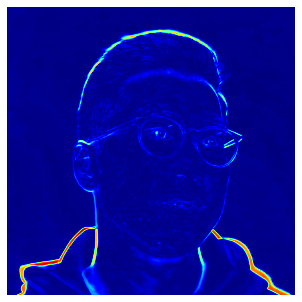

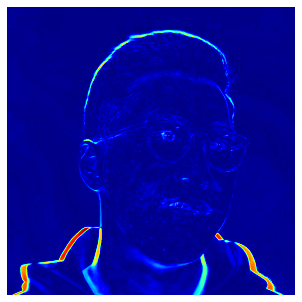

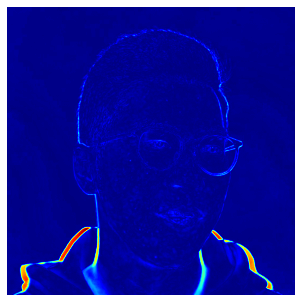

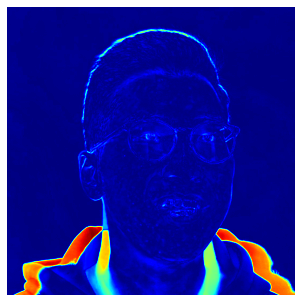

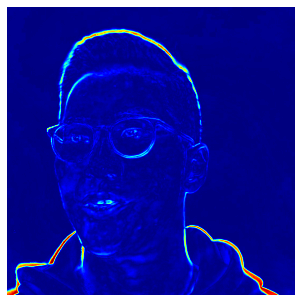

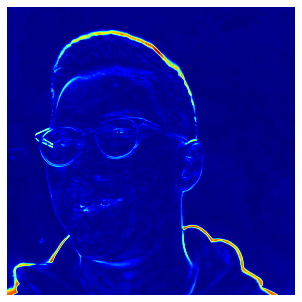

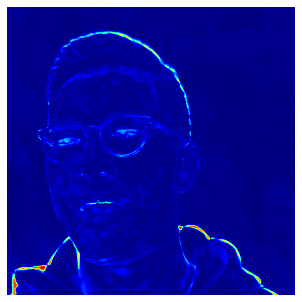

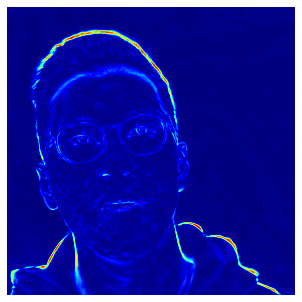

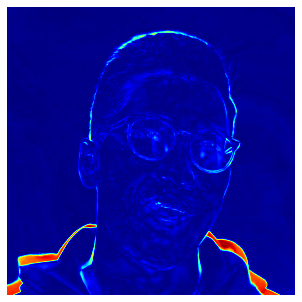

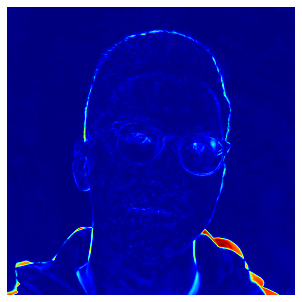

In [ ]:
config = './real_data/person_1/person_1_config.yml'
checkpoint = './logs/person_1/checkpoint565000.ckpt'
savedir = './renderings/person_1'
eval(config, checkpoint, savedir)

In [23]:
rgbs = []
!pip install imageio_ffmpeg
frames = glob.glob('./renderings/person_1/*.png')
for _fname in frames:
    rgbs.append(imageio.imread(_fname))
imageio.mimwrite(os.path.join('./renderings/person_1', 'video.mp4'), rgbs, fps=47, quality=8)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
from IPython.display import HTML
from base64 import b64encode
testsavedir = './renderings/person_1'

mp4 = open(os.path.join(testsavedir, 'video.mp4'),'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Output hidden; open in https://colab.research.google.com to view.

In [26]:
gt_dir = './real_data/person_1/person_1_test.mp4'
mp4 = open(os.path.join(testsavedir, 'video.mp4'),'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Output hidden; open in https://colab.research.google.com to view.